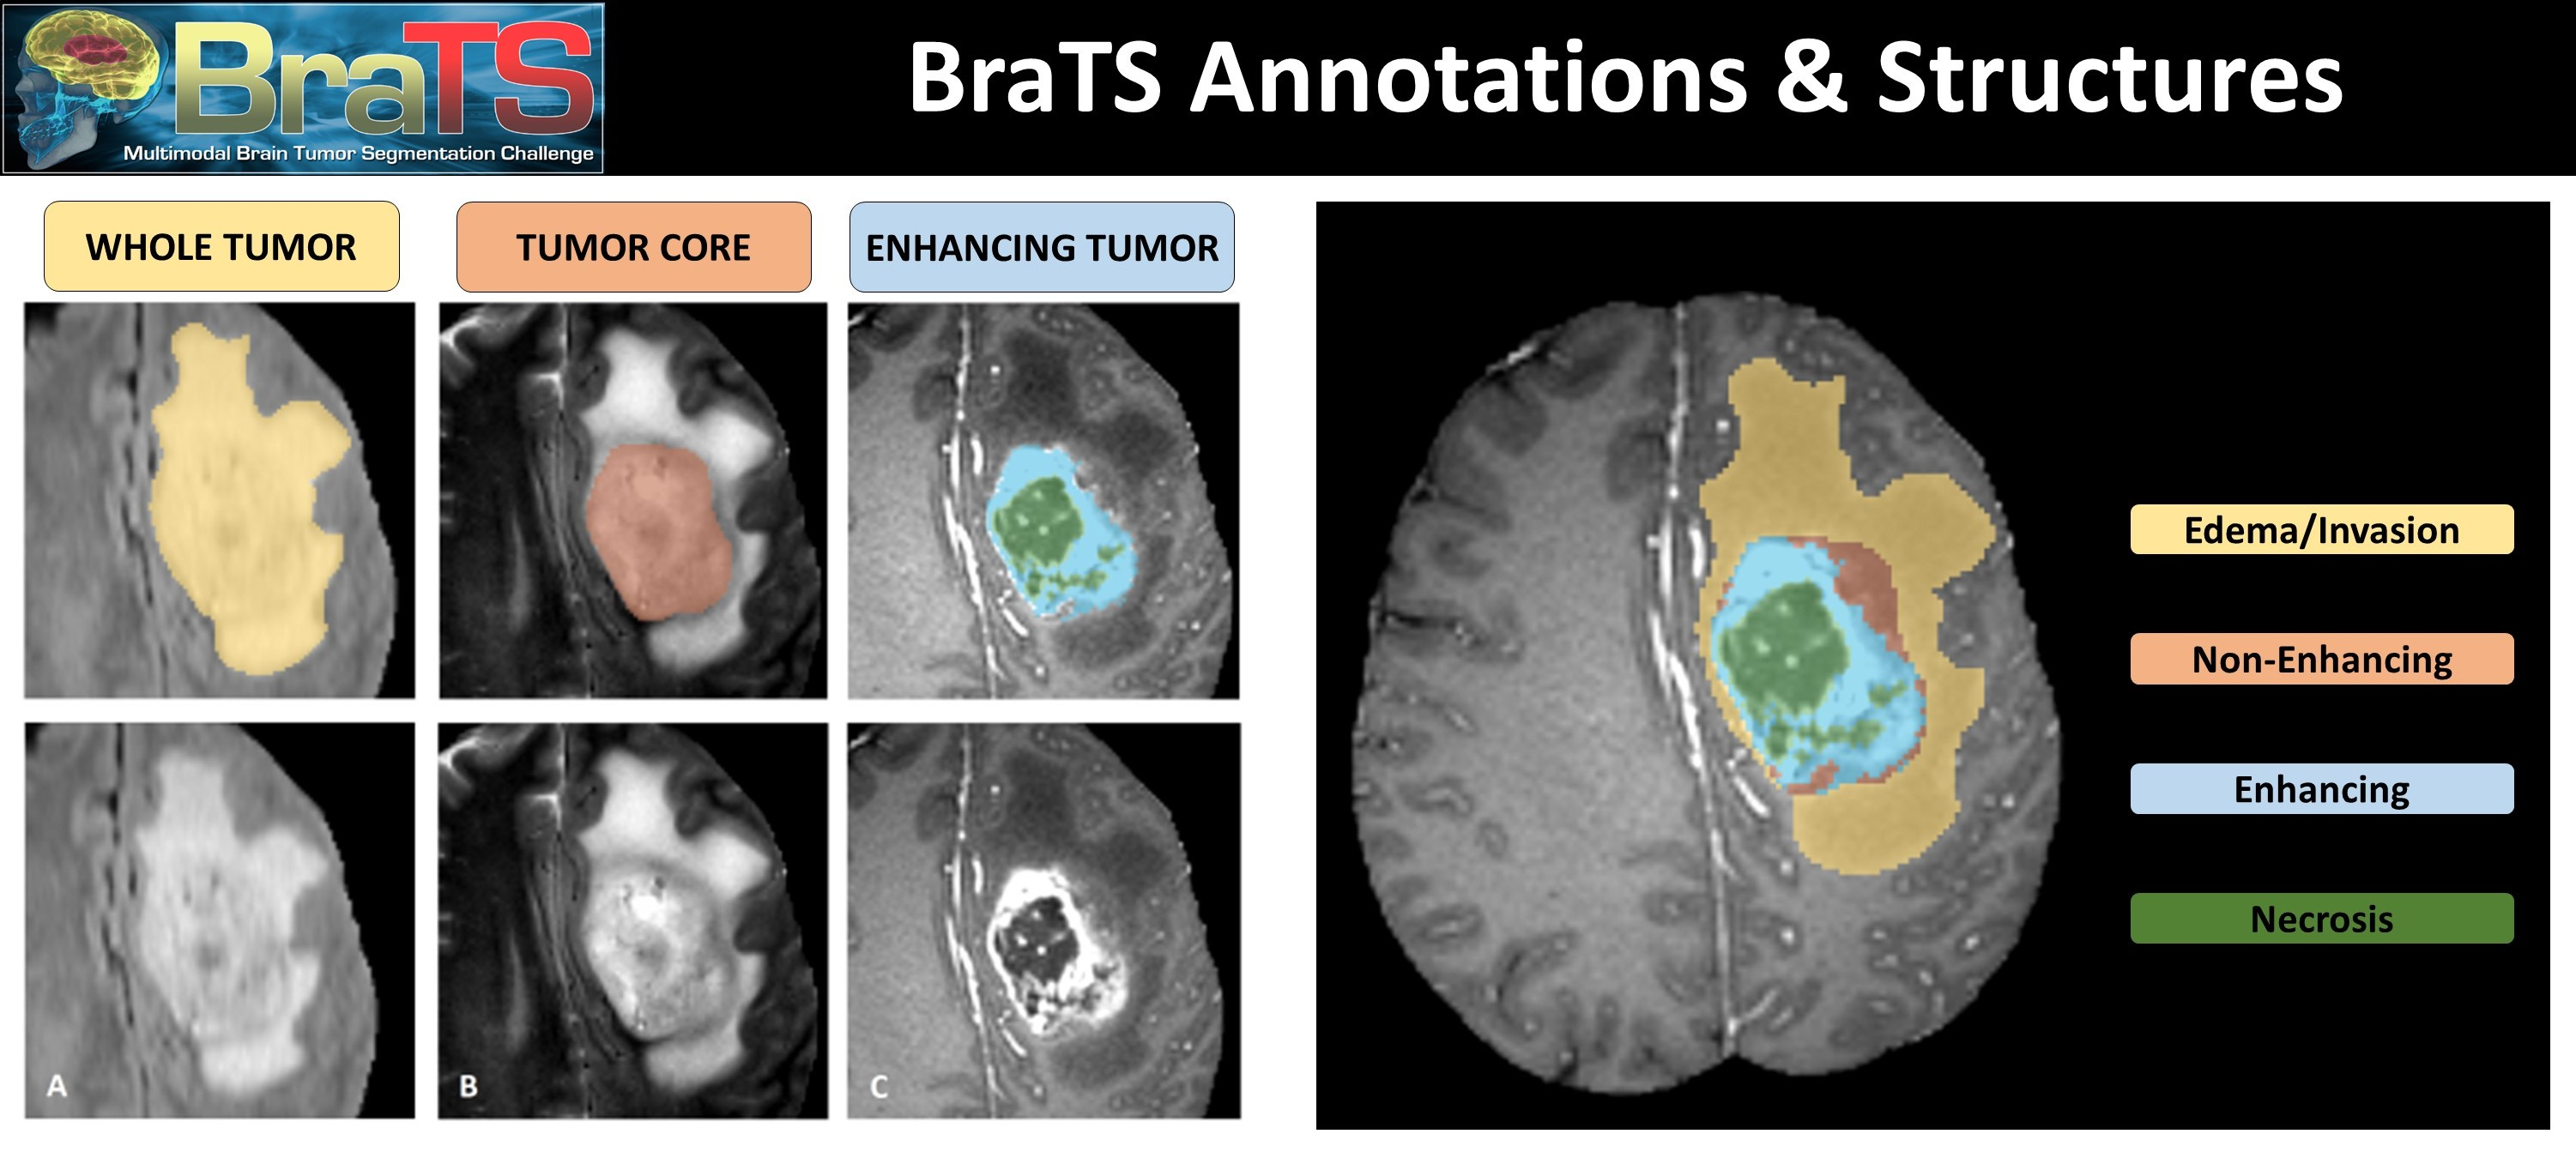

# Import Library

In [1]:
import numpy as np
import tensorflow as tf
# from tensorflow import keras
import keras
import glob
import gc
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D, Lambda,Concatenate, Maximum, MaxPooling2D,Dropout
from keras import regularizers
from keras.models import Model
import random as rd
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.utils import shuffle,Sequence
from tensorflow.keras.utils import plot_model
import time
from tqdm import tqdm
from sklearn import metrics
# rd.seed(21)

# BUILDING MODEL

## 1. Original Model : InputCascadeCNN

In [2]:
def TwoPathWayCNN0(input_img):
    #2 tham số mặc định cho Conv2D: strides=(1,1),padding='valid'

    #PATHWAY 1:   
    #Layer1: Tạo 2 lớp converlution 7x7 -> Maxout -> MaxPooling
        #conv 7x7
    Out1 = Conv2D(filters= 64,kernel_size =(7,7),strides=(1,1))(input_img)
    Out2 = Conv2D(filters= 64,kernel_size =(7,7),strides=(1,1))(input_img)
        #maxout 2 conv
    Max_O  = Maximum()([Out1,Out2]) 
        #max pooling
    Max_O = MaxPooling2D(pool_size=(4,4),strides=(1,1))(Max_O)

    #Layer2: Tạo 2 lớp converlution 3x3 -> Maxout -> MaxPooling
    Out3 = Conv2D(filters= 64,kernel_size =(3,3),strides=(1,1))(Max_O)
#     Out3 = BatchNormalization()(Out3)
    Out4 = Conv2D(filters= 64,kernel_size =(3,3),strides=(1,1))(Max_O)
#     Out4 = BatchNormalization()(Out4)
    Max_O = Maximum()([Out3,Out4])
    Max_O = MaxPooling2D(pool_size=(2,2),strides=(1,1))(Max_O)

    #PATHWAY 2:  
    Out5=Conv2D(filters= 160,kernel_size =(13,13),strides=(1,1))(input_img)
#     Out5 = BatchNormalization()(Out5)
    Out6=Conv2D(filters= 160,kernel_size =(13,13),strides=(1,1))(input_img)
#     Out6 = BatchNormalization()(Out6)
    Max_O3 = Maximum()([Out5,Out6])
    
    # Kêt hợp(Concatenation) 2 pathway
    final_out = Concatenate()([Max_O,Max_O3])
    return final_out


def InputCascadeCNN0(): 
    #(65,65,4) input img
    Input1 = Input((65,65,4))
    #(33,33,4) input img
    Input2 = Input((33,33,4))    
    Out_1 = TwoPathWayCNN0(Input1)

    Out_1 = Conv2D(5,(21,21),strides=(1,1),activation='relu')(Out_1)
    Out_2 = Concatenate()([Out_1,Input2])
  
    final_out = TwoPathWayCNN0(Out_2)
    final_out = Conv2D(5,(21,21),strides=(1,1))(final_out)
    final_out = Activation('softmax')(final_out)
    cascade_model = Model(inputs = [Input1, Input2], outputs = final_out )
    

    return cascade_model

In [3]:
#Initialization of the model and its summary
model0=InputCascadeCNN0()
model0.summary()

2023-02-02 19:19:25.899169: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-02 19:19:26.130595: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-02 19:19:26.131512: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-02 19:19:26.132975: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 65, 65, 4)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 59, 59, 64)   12608       input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 59, 59, 64)   12608       input_1[0][0]                    
__________________________________________________________________________________________________
maximum (Maximum)               (None, 59, 59, 64)   0           conv2d[0][0]                     
                                                                 conv2d_1[0][0]               

## 2. Improved Model 2: InputCascadeCNN v2

In [3]:
def TwoPathWayCNN2(input_img):

    #PATHWAY 1:   
    #Layer1: Tạo 2 lớp converlution 7x7 -> Maxout -> MaxPooling
        #conv 7x7
    Out1 = Conv2D(filters= 64,kernel_size =(7,7),strides=(1,1),padding='valid')(input_img)
    Out1 = BatchNormalization()(Out1)
    Out2 = Conv2D(filters= 64,kernel_size =(7,7),strides=(1,1),padding='valid')(input_img)
    Out2 = BatchNormalization()(Out2)
        #maxout 2 conv
    Max_O  = Maximum()([Out1,Out2]) 
        #max pooling
#     Max_O = MaxPooling2D(pool_size=(4,4),strides=(1,1),padding='valid')(Max_O) #-> convert to Conv2D 
    Max_O = Conv2D(filters=64,kernel_size=(4,4),strides=(1,1),padding='valid', activation='relu')(Max_O)
    # 
  
    #Layer2: Tạo 2 lớp converlution 3x3 -> Maxout -> MaxPooling
    Out3 = Conv2D(filters= 64,kernel_size =(3,3),strides=(1,1),padding='valid')(Max_O)
    Out3 = BatchNormalization()(Out3)
    Out4 = Conv2D(filters= 64,kernel_size =(3,3),strides=(1,1),padding='valid')(Max_O)
    Out4 = BatchNormalization()(Out4)
    Max_O = Maximum()([Out3,Out4])
#     Max_O = MaxPooling2D(pool_size=(2,2),strides=(1,1))(Max_O)
    Max_O = Conv2D(filters=64,kernel_size=(2,2),strides=(1,1),padding='valid',activation='relu')(Max_O)
    
    #PATHWAY 2:  
    Out5=Conv2D(filters= 160,kernel_size =(13,13),strides=(1,1),padding='valid')(input_img)
    Out5 = BatchNormalization()(Out5)
    Out6=Conv2D(filters= 160,kernel_size =(13,13),strides=(1,1),padding='valid')(input_img)
    Out6 = BatchNormalization()(Out6)
    Max_O3 = Maximum()([Out5,Out6])
    
    # Kêt hợp(Concatenation) 2 pathway
    final_out = Concatenate()([Max_O,Max_O3])
    return final_out

def InputCascadeCNN2():
    #(65,65,4) input img
    Input1 = Input((65,65,4)) 
    #(33,33,4) input img
    Input2 = Input((33,33,4))    
    Out_1 = TwoPathWayCNN2(Input1)
    Out_1 = Conv2D(5,(21,21),strides=(1,1),padding='valid',activation='relu')(Out_1)
    Out_1 = BatchNormalization()(Out_1)

    Out_2 = Concatenate()([Out_1,Input2])
  
    final_out = TwoPathWayCNN2(Out_2)
    final_out = Conv2D(5,(21,21),strides=(1,1),padding='valid')(final_out)
    final_out = BatchNormalization()(final_out)
    final_out = Activation('softmax')(final_out)
    cascade_model = Model(inputs = [Input1, Input2], outputs = final_out )
    

    return cascade_model

In [8]:
#Initialization of the model and its summary
model2=InputCascadeCNN2()
model2.summary()

2023-02-02 18:16:17.198166: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-02 18:16:17.447813: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-02 18:16:17.448919: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-02 18:16:17.450853: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 65, 65, 4)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 59, 59, 64)   12608       input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 59, 59, 64)   12608       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 59, 59, 64)   256         conv2d[0][0]                     
______________________________________________________________________________________________

## 2. Improved Model 1: InputCascadeCNN v1

In [4]:
def TwoPathWayCNN1(input_img):

    #PATHWAY 1:   
    #Layer1: Tạo 2 lớp converlution 7x7 -> Maxout -> MaxPooling
        #conv 7x7
    Out1 = Conv2D(filters= 64,kernel_size =(7,7),strides=(1,1),padding='valid')(input_img)
    Out1 = BatchNormalization()(Out1)
    Out2 = Conv2D(filters= 64,kernel_size =(7,7),strides=(1,1),padding='valid')(input_img)
    Out2 = BatchNormalization()(Out2)
        #maxout 2 conv
    Max_O  = Maximum()([Out1,Out2]) 
        #max pooling
    Max_O = MaxPooling2D(pool_size=(4,4),strides=(1,1),padding='valid')(Max_O) #-> convert to Conv2D 

  
    #Layer2: Tạo 2 lớp converlution 3x3 -> Maxout -> MaxPooling
    Out3 = Conv2D(filters= 64,kernel_size =(3,3),strides=(1,1),padding='valid')(Max_O)
    Out3 = BatchNormalization()(Out3)
    Out4 = Conv2D(filters= 64,kernel_size =(3,3),strides=(1,1),padding='valid')(Max_O)
    Out4 = BatchNormalization()(Out4)
    Max_O = Maximum()([Out3,Out4])
    Max_O = MaxPooling2D(pool_size=(2,2),strides=(1,1))(Max_O)

    #PATHWAY 2:  
    Out5=Conv2D(filters= 160,kernel_size =(13,13),strides=(1,1),padding='valid')(input_img)
    Out5 = BatchNormalization()(Out5)
    Out6=Conv2D(filters= 160,kernel_size =(13,13),strides=(1,1),padding='valid')(input_img)
    Out6 = BatchNormalization()(Out6)
    Max_O3 = Maximum()([Out5,Out6])
    
    # Kêt hợp(Concatenation) 2 pathway
    final_out = Concatenate()([Max_O,Max_O3])
    return final_out


def InputCascadeCNN1():
    #(65,65,4) input img
    Input1 = Input((65,65,4)) 
    #(33,33,4) input img
    Input2 = Input((33,33,4))    
    Out_1 = TwoPathWayCNN1(Input1)
    Out_1 = Conv2D(5,(21,21),strides=(1,1),padding='valid',activation='relu')(Out_1)
    Out_1 = BatchNormalization()(Out_1)

    Out_2 = Concatenate()([Out_1,Input2])
  
    final_out = TwoPathWayCNN1(Out_2)
    final_out = Conv2D(5,(21,21),strides=(1,1),padding='valid')(final_out)
    final_out = BatchNormalization()(final_out)
    final_out = Activation('softmax')(final_out)
    cascade_model = Model(inputs = [Input1, Input2], outputs = final_out )
    

    return cascade_model

In [4]:
model1=InputCascadeCNN1()
model1.summary()

2023-02-02 18:01:16.848250: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-02 18:01:17.011902: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-02 18:01:17.012785: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-02 18:01:17.014016: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 65, 65, 4)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 59, 59, 64)   12608       input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 59, 59, 64)   12608       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 59, 59, 64)   256         conv2d[0][0]                     
______________________________________________________________________________________________

# Function serve for training

In [6]:
#Đọc 1 bộ brain dataset gồm 5 ảnh 3D với 4 ảnh chup não theo 4
#phương thức: path_flair,path_t1,path_t1c,path_t2 và ảnh ảnh phân đoạn gt 
#1 Ảnh 3D có chiều là (155, 240, 240)
# Sau khi đọc 4 loại ảnh trên, ta cần nhóm các mặt cắt của từng bộ não với nhau, 
#vào xếp chồng lên nhau với chiều là (155, 240, 240,4)
import SimpleITK as sitk
def loadImg(path):
    img = sitk.ReadImage(path)
    return sitk.GetArrayFromImage(img)

def read_brain(patient_path):  
    #input1: patient_path, là đường dẫn đến thư mục chứa các bức ảnh
  # patient='./BRATS2015_Training/HGG/brats_2013_pat0001_1'
  # Đọc đường dẫn hình ảnh brain cho 5 loại của 1 patient
  # paths=[path_flair,path_t1,path_t1c,path_t2,path_gt]

    Types=['flair.','t1.','t1ce.','t2.','seg.']
    paths= [glob.glob(patient_path+'/**{}**nii'.format(t))[0] for t in Types]
  # Đọc data 3D img 
    
    [img_flair ,img_t1, img_t1c ,img_t2, img_gt]=[ loadImg(path) for path in paths ]
    brain_img_4d = np.zeros((155, 240, 240,4))
    #Cắt lát từng bộ não
    for idx in range(155):
        brain_img_4d[idx] = np.dstack([img_flair[idx,:,:],
                                          img_t1[idx,:,:], 
                                          img_t1c[idx,:,:],
                                          img_t2[idx,:,:] ])
    #trả về data train và lable 
    return brain_img_4d, img_gt




def generate_patch_by_one_brain(brain_path,patch_per_brain):
    img_data_train, img_lable = read_brain(brain_path)
    lables= [0,1,2,4]
    count=0
    p65s=np.zeros((patch_per_brain, 65, 65, 4))
    p33s=np.zeros((patch_per_brain, 33, 33, 4))
    gt=np.zeros(patch_per_brain,dtype='int')
    patch_per_class=int(patch_per_brain/len(lables))
    new_img_lable=img_lable[40:120,32:200,32:200]
    for lable in lables:
        l=lable
        array_indexs=np.argwhere(new_img_lable==l)
        if(len(array_indexs)<patch_per_class): 
            array_indexs=np.argwhere(new_img_lable==0)
            l=0
       
        idxs=np.random.choice(len(array_indexs),patch_per_class,replace=False)
        for i in idxs:
            _slice,x,y= array_indexs[i]
            p65= img_data_train[_slice+40,x:x+65,y:y+65,:]
            p33 = p65[16:49, 16:49,:]
#             if(p33.any()==False): continue 
            p65s[count]=p65
            p33s[count]=p33
            del p65;del p33
            gt[count]=l
            count+=1
    return p65s,p33s,gt




def generate_data_for_model(number_patch,brain_paths):
    patches_65= []; patches_33= []; actual_gt = []
#     indexs=np.random.choice(max_brain,max_brain)
    num_patch_per_brain=int(number_patch/len(brain_paths))
    for i in tqdm(range(len(brain_paths))):
        ps_65,ps_33,gt=generate_patch_by_one_brain(brain_paths[i],num_patch_per_brain)
        patches_65.extend(ps_65)
        patches_33.extend(ps_33)
        actual_gt.extend(gt)
        
    patches_65, patches_33,actual_gt= shuffle(patches_65, patches_33,actual_gt)    

    y_data = np.zeros((number_patch, 1, 1, 5))
    for i in range(number_patch):
        y_data[i, :, :, actual_gt[i]] = 1
    print(np.unique(actual_gt, return_counts=True),number_patch)
    patches_65=np.array(patches_65)
    patches_33=np.array(patches_33)
    
    x_data= [patches_65, patches_33]
    
    return x_data,y_data


def create_patch_for_segmentation_predict(data_train_img, data_label, no_slice):
    patches65 =np.zeros((150*150, 65, 65, 4))
    patches33 =np.zeros((150*150, 33, 33, 4))
    actual_gt = np.zeros(150*150, dtype=int)
    k = 0
    for i in range(10, 160):
        for j in range(10, 160):
            patch = data_train_img[no_slice, i:i+65, j:j+65, :]
            s_patch = patch[16:49, 16:49, :]
            patches65[k]=patch
            patches33[k]=s_patch
            key = data_label[no_slice, i+32, j+32 ]
            actual_gt[k] = key
            k = k+1
            del patch
            del s_patch
      
    return patches65, patches33, actual_gt

def show_segmentation_predict(y_pred):
    y_predict = np.argmax(np.reshape(y_pred,(150*150,5)),axis =1)
    img = np.reshape(y_predict,(150,150))
    final = np.zeros((240,240))
    final[42:192,42:192] =img
    plt.imshow(final)
    plt.show()
def plot_history(info):
    plt.ylim(0.5, 1)
    plt.plot(info.history['accuracy'])
    plt.plot(info.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

# Generate patchs for training and validation

In [7]:
brain_paths=np.array(sorted(glob.glob("../input/**/BraTS2020_TrainingData/**/**")))

brain_test_paths=brain_paths[:10]
brain_val_paths=brain_paths[10:30]
brain_train_paths=brain_paths[30:130]

x_val,y_val=generate_data_for_model(4000,brain_val_paths)
x_train,y_train=generate_data_for_model(24000,brain_train_paths)
gc.collect() 

100%|██████████| 20/20 [00:22<00:00,  1.13s/it]


(array([0, 1, 2, 4]), array([1000, 1000, 1000, 1000])) 4000


100%|██████████| 100/100 [02:01<00:00,  1.22s/it]


(array([0, 1, 2, 4]), array([6120, 5880, 6000, 6000])) 24000


4621

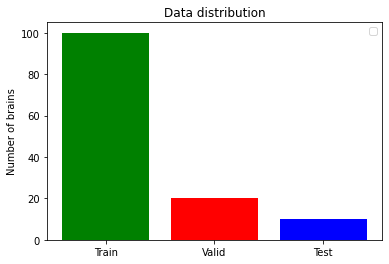

In [8]:
plt.bar(["Train","Valid","Test"],
[len(brain_train_paths),len(brain_val_paths) ,len(brain_test_paths)], align='center',color=[ 'green','red', 'blue'])
plt.legend()

plt.ylabel('Number of brains')
plt.title('Data distribution')

plt.show()
    

In [12]:
gc.collect() 

23

# TRAINING

### 1. Training Original Model

In [8]:
model0.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
info=model0.fit(
                x=x_train,
                y=y_train,
                epochs=15,
                batch_size = 128,
                validation_data=(x_val,y_val),
    )


2023-01-30 04:28:09.207285: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2028000000 exceeds 10% of free system memory.
2023-01-30 04:28:12.543055: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2028000000 exceeds 10% of free system memory.
2023-01-30 04:28:14.894301: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15


2023-01-30 04:28:16.809602: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


118/118 [==============================] - 61s 417ms/step - loss: 4186.2764 - accuracy: 0.5819 - val_loss: 745.3665 - val_accuracy: 0.7243
Epoch 2/15
118/118 [==============================] - 46s 389ms/step - loss: 517.2759 - accuracy: 0.6997 - val_loss: 819.7338 - val_accuracy: 0.6637
Epoch 3/15
118/118 [==============================] - 46s 389ms/step - loss: 322.0104 - accuracy: 0.7389 - val_loss: 452.4743 - val_accuracy: 0.7462
Epoch 4/15
118/118 [==============================] - 46s 389ms/step - loss: 158.1503 - accuracy: 0.7665 - val_loss: 439.0793 - val_accuracy: 0.6355
Epoch 5/15
118/118 [==============================] - 46s 388ms/step - loss: 106.2630 - accuracy: 0.7914 - val_loss: 142.1456 - val_accuracy: 0.7750
Epoch 6/15
118/118 [==============================] - 46s 388ms/step - loss: 47.4364 - accuracy: 0.8150 - val_loss: 116.7252 - val_accuracy: 0.7490
Epoch 7/15
118/118 [==============================] - 46s 388ms/step - loss: 61.4657 - accuracy: 0.8056 - val_loss: 7

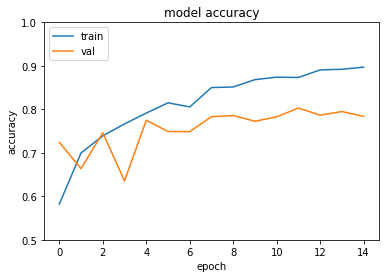

In [11]:
plot_history(info)

In [12]:
# Save weight
model0.save("weight_v0.h5")

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


## Training improved model 1

In [8]:
model1.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
info=model1.fit(
                x=x_train,
                y=y_train,
                epochs=15,
                batch_size = 128,
                validation_data=(x_val,y_val)
)


2023-01-27 07:34:49.128471: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2028000000 exceeds 10% of free system memory.
2023-01-27 07:34:52.662501: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2028000000 exceeds 10% of free system memory.
2023-01-27 07:34:55.055667: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15


2023-01-27 07:34:57.445584: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


118/118 [==============================] - 68s 465ms/step - loss: 0.8678 - accuracy: 0.7387 - val_loss: 1.3570 - val_accuracy: 0.5935
Epoch 2/15
118/118 [==============================] - 51s 434ms/step - loss: 0.6316 - accuracy: 0.8485 - val_loss: 0.9356 - val_accuracy: 0.7412
Epoch 3/15
118/118 [==============================] - 51s 434ms/step - loss: 0.5283 - accuracy: 0.8733 - val_loss: 0.9006 - val_accuracy: 0.7175
Epoch 4/15
118/118 [==============================] - 51s 434ms/step - loss: 0.4531 - accuracy: 0.8905 - val_loss: 0.7415 - val_accuracy: 0.7890
Epoch 5/15
118/118 [==============================] - 51s 433ms/step - loss: 0.4016 - accuracy: 0.8992 - val_loss: 0.6409 - val_accuracy: 0.8025
Epoch 6/15
118/118 [==============================] - 51s 433ms/step - loss: 0.3671 - accuracy: 0.9057 - val_loss: 0.6410 - val_accuracy: 0.8080
Epoch 7/15
118/118 [==============================] - 51s 433ms/step - loss: 0.3327 - accuracy: 0.9130 - val_loss: 0.6652 - val_accuracy: 0.7

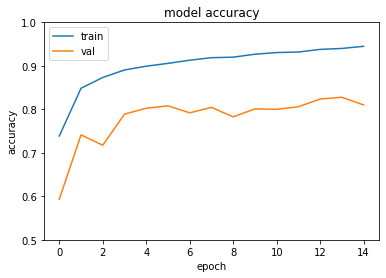

In [10]:
plot_history(info)

In [13]:
# Save weight
model1.save("weight_v1.h5")

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


### 2. Training Improved Model 2

In [13]:

model2.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
info=model2.fit(
                x=x_train,
                y=y_train,
                epochs=15,
                batch_size = 128,
                validation_data=(x_val,y_val)
)

del x_train
del y_train

2023-01-27 08:14:53.422044: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2028000000 exceeds 10% of free system memory.
2023-01-27 08:14:56.832387: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2028000000 exceeds 10% of free system memory.
2023-01-27 08:14:59.022712: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15


2023-01-27 08:15:01.777113: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


118/118 [==============================] - 72s 493ms/step - loss: 0.8498 - accuracy: 0.7431 - val_loss: 1.4117 - val_accuracy: 0.5990
Epoch 2/15
118/118 [==============================] - 54s 457ms/step - loss: 0.6109 - accuracy: 0.8523 - val_loss: 1.2218 - val_accuracy: 0.5675
Epoch 3/15
118/118 [==============================] - 54s 457ms/step - loss: 0.5018 - accuracy: 0.8817 - val_loss: 0.7205 - val_accuracy: 0.7908
Epoch 4/15
118/118 [==============================] - 54s 457ms/step - loss: 0.4342 - accuracy: 0.8952 - val_loss: 0.7610 - val_accuracy: 0.7452
Epoch 5/15
118/118 [==============================] - 54s 457ms/step - loss: 0.3862 - accuracy: 0.9039 - val_loss: 0.6266 - val_accuracy: 0.8052
Epoch 6/15
118/118 [==============================] - 54s 457ms/step - loss: 0.3496 - accuracy: 0.9104 - val_loss: 0.6029 - val_accuracy: 0.8005
Epoch 7/15
118/118 [==============================] - 54s 457ms/step - loss: 0.3160 - accuracy: 0.9179 - val_loss: 0.6504 - val_accuracy: 0.7

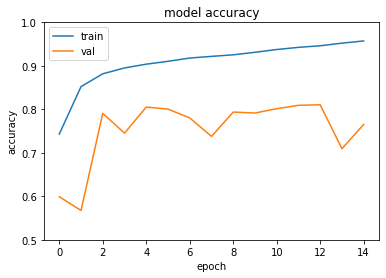

In [15]:
plot_history(info)

In [13]:
# Save weight
model2.save("weight_v2.h5")

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


# Testing

In [8]:
#load weight
model0=InputCascadeCNN0()
model1=InputCascadeCNN1()
model2=InputCascadeCNN2()
model0.load_weights("/kaggle/input/braintsweights/weight_0.h5")
model1.load_weights("/kaggle/input/braintsweights/weight_1.h5")
model2.load_weights("/kaggle/input/braintsweights/weight_2.h5")

In [9]:
patients_path=sorted(glob.glob("../input/**/BraTS2020_TrainingData/**/**"))
brain_test_paths=patients_path[:10]
brain_img_4d, image_gt=read_brain(patient_path=brain_test_paths[5])

Text(0.5, 1.0, 'Ground truth')

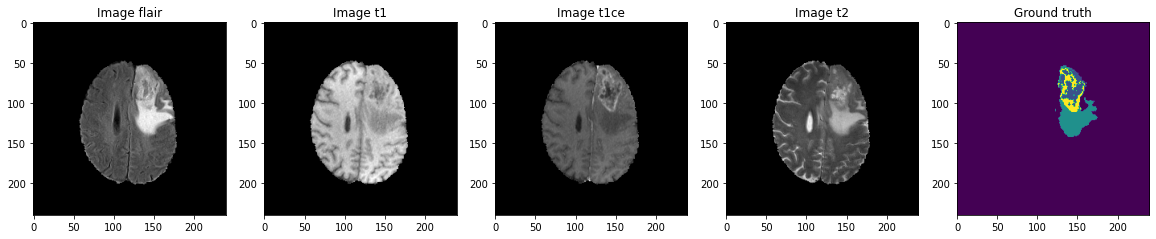

In [12]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 10))
ax1.imshow(brain_img_4d[100,:,:,0],cmap='gray')
ax1.set_title('Image flair')
ax2.imshow(brain_img_4d[100,:,:,1],cmap='gray')
ax2.set_title('Image t1')
ax3.imshow(brain_img_4d[100,:,:,2],cmap='gray')
ax3.set_title('Image t1ce')
ax4.imshow(brain_img_4d[100,:,:,3],cmap='gray')
ax4.set_title('Image t2')
ax5.imshow(image_gt[100])
ax5.set_title('Ground truth')

<b> Ground trust

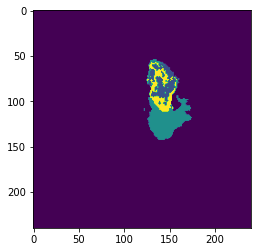

In [20]:
brain_slice=100
patches65, patches33, label=create_patch_for_segmentation_predict(brain_img_4d, image_gt,brain_slice)
plt.imshow(image_gt[brain_slice])
plt.show()


<b> Prediction

In [21]:
# y_predict0=model0.predict(x=[patches65,patches33],batch_size=128,verbose=1)
# y_predict1=model1.predict(x=[patches65,patches33],batch_size=128,verbose=1)
y_predict2=model2.predict(x=[patches65,patches33],batch_size=128,verbose=1)

del patches65
del patches33

2023-02-08 05:16:12.376278: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1521000000 exceeds 10% of free system memory.


176/176 [==============================] - 11s 59ms/step


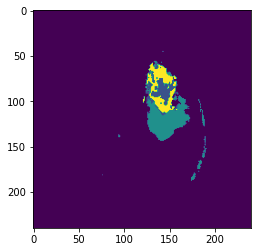

In [13]:
#Result from InputCascadeCNN
show_segmentation_predict(y_predict0)

In [16]:
y_pre0= np.argmax(np.reshape(y_predict0,(22500,5)),axis=1)
print("MODEL 0\n",metrics.classification_report(label,y_pre0))

MODEL 0
               precision    recall  f1-score   support

           0       0.99      0.98      0.98     19882
           1       0.68      0.52      0.59       685
           2       0.76      0.86      0.81      1325
           4       0.69      0.85      0.76       608

    accuracy                           0.96     22500
   macro avg       0.78      0.80      0.79     22500
weighted avg       0.96      0.96      0.96     22500



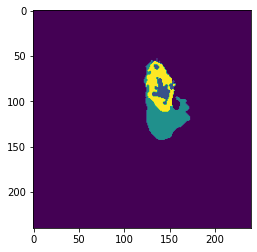

In [16]:
#Result from InputCascadeCNN v1
show_segmentation_predict(y_predict1)

In [19]:
y_pre1= np.argmax(np.reshape(y_predict1,(22500,5)),axis=1)
print("MODEL 1\n",metrics.classification_report(label,y_pre1))

MODEL 1
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     19882
           1       0.91      0.45      0.60       685
           2       0.83      0.93      0.88      1325
           4       0.62      0.90      0.73       608

    accuracy                           0.96     22500
   macro avg       0.84      0.81      0.80     22500
weighted avg       0.97      0.96      0.96     22500



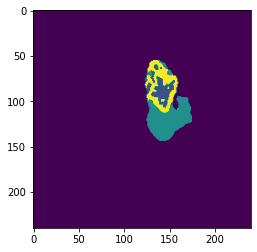

In [17]:
#Result from InputCascadeCNN v2
show_segmentation_predict(y_predict2)

In [24]:
y_pre2= np.argmax(np.reshape(y_predict2,(22500,5)),axis=1)
print("MODEL 2\n",metrics.classification_report(label,y_pre2))

MODEL 2
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     19882
           1       0.74      0.59      0.66       685
           2       0.80      0.94      0.86      1325
           4       0.61      0.86      0.71       608

    accuracy                           0.96     22500
   macro avg       0.79      0.84      0.80     22500
weighted avg       0.97      0.96      0.96     22500



## Metrics

In [25]:
brain_paths=sorted(glob.glob("../input/**/BraTS2020_TrainingData/**/**"))
brain_test_paths=brain_paths[:10]
x_test,y_test=generate_data_for_model(10000,brain_test_paths)
y_predict0= model0.predict(x=x_test)
y_predict1= model1.predict(x=x_test)
y_predict2= model2.predict(x=x_test)
y_pre0= np.argmax(np.reshape(y_predict0,(10000,5)),axis=1)
y_pre1= np.argmax(np.reshape(y_predict1,(10000,5)),axis=1)
y_pre2= np.argmax(np.reshape(y_predict2,(10000,5)),axis=1)
y_test= np.argmax(np.reshape(y_test,(10000,5)),axis =1)
del x_test

100%|██████████| 10/10 [00:13<00:00,  1.39s/it]


(array([0, 1, 2, 4]), array([2750, 2250, 2500, 2500])) 10000


<b> InputCascadeCNN 

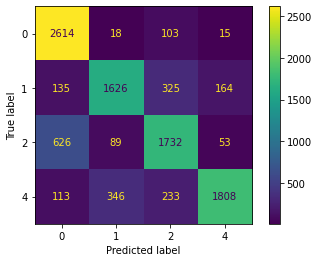

In [26]:
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pre0)
plt.show()

In [23]:
print("MODEL 0\n",metrics.classification_report(y_test,y_pre0))

MODEL 0
               precision    recall  f1-score   support

           0       0.76      0.94      0.84      2750
           1       0.77      0.72      0.75      2250
           2       0.70      0.69      0.70      2500
           4       0.88      0.70      0.78      2500

    accuracy                           0.77     10000
   macro avg       0.78      0.77      0.77     10000
weighted avg       0.78      0.77      0.77     10000



<b> InputCascadeCNN v1

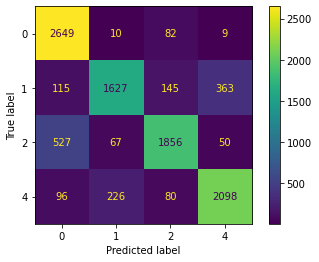

In [28]:
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pre1)
plt.show()

In [24]:
print("MODEL 1\n",metrics.classification_report(y_test,y_pre1))

MODEL 1
               precision    recall  f1-score   support

           0       0.79      0.96      0.87      2750
           1       0.85      0.72      0.78      2250
           2       0.85      0.75      0.80      2500
           4       0.82      0.83      0.83      2500

    accuracy                           0.82     10000
   macro avg       0.83      0.82      0.82     10000
weighted avg       0.83      0.82      0.82     10000



<b> InputCascadeCNN v2

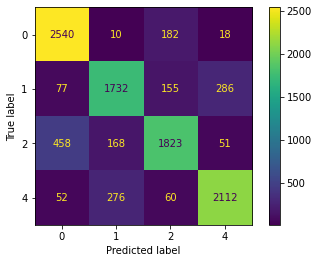

In [30]:
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pre2)
plt.show()

In [25]:
print("MODEL 2\n",metrics.classification_report(y_test,y_pre2))

MODEL 2
               precision    recall  f1-score   support

           0       0.83      0.91      0.87      2750
           1       0.80      0.77      0.78      2250
           2       0.81      0.74      0.77      2500
           4       0.84      0.84      0.84      2500

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000



In [ ]:
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pre0)
plt.show()